In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geoplot as gplt
from scipy.stats import iqr, skew, kurtosis, pearsonr
import contextily as ctx #Used in conjuction with matplotlib/geopandas to set a basemap

In [2]:
import_fp = Path("../data/processed/istanbul_airbnb_processed.csv")
airbnb_df = pd.read_csv(import_fp, encoding = "utf-8-sig")

import_fp = Path("../data/processed/istanbul_airbnb_processed_shapefile.shp")
airbnb_gdf = gpd.read_file(import_fp)

import_fp = Path("../data/external/district_income.xlsx")
extra_stats_df = pd.read_excel(import_fp, sheet_name = "main")

import_fp = Path("../data/external/istanbul_districts.shp")
istanbul_districts_gdf = gpd.read_file(import_fp)

import_fp = Path("../data/processed/htourism_centers_processed.shp")
htourism_gdf = gpd.read_file(import_fp)

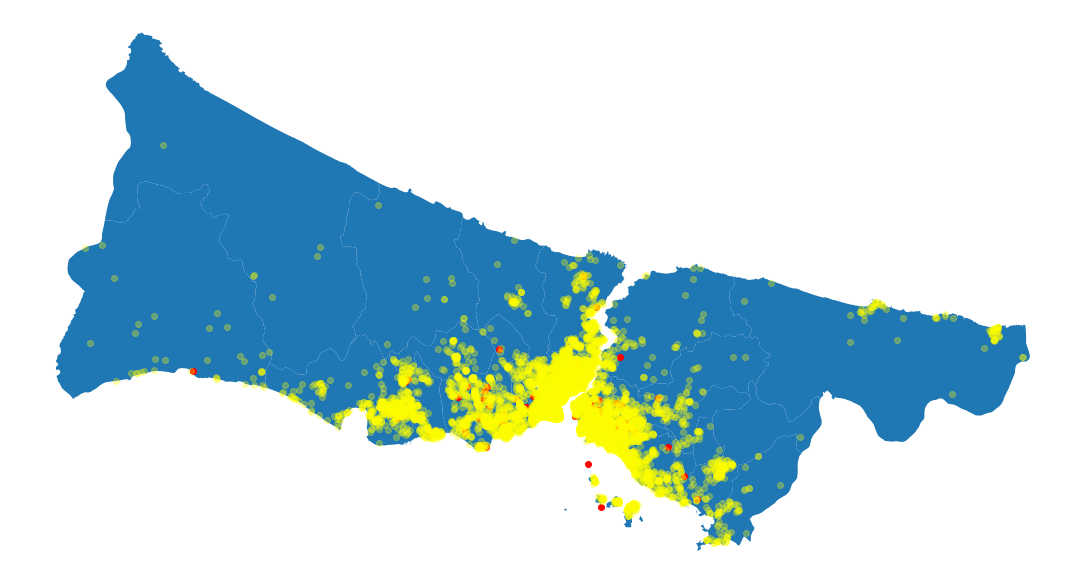

In [3]:

fig = plt.figure(figsize = (19.20,19.20))

ax_1 = fig.add_subplot(1,1,1)

#                            --- MAP: ---

# --- Plot Figure ---

istanbul_districts_gdf.plot(ax = ax_1)

htourism_gdf.plot(ax = ax_1,
               color = "red",
               alpha = 1)

airbnb_gdf.plot(ax = ax_1,
               color = "yellow",
               alpha = 0.3)

# --- Set Basemap ---


# --- Spine and Grid ---

ax_1.set_axis_off() # Turn off axis

In [14]:
def nearest_neighbor_analysis(gdf1, gdf2):
    '''
Accepts as an an argument two Geopandas GeoDataFrames
Takes the gdf1 as the GeoDataFrame of origin and gdf2 as the GeoDataFrame of query
For each element of gdf1, finds which element of gdf2 is closest and also calculates the distance
Returns a GeoDataFrame containing origin geometry, nearest geometry and the distance in meters

NOTE: gdf2 is turned into a MultiPoint object first through unary union.
NOTE: This method is extremely slow as it is not vectorized. Proceed with caution.
Note: The distance is calculated via geopy 
    '''
    
# Import required modules
    from geopy import distance

#Calculate the centroid of gdf2

    gdf2_copy = gdf2.copy()

    gdf2_copy["centroid"] = gdf2_copy.geometry.centroid

#Set geometry of gdf2_copy
    gdf2_copy.set_geometry("centroid", inplace = True)
    
#Take the unary union of gdf2_copy
    gdf2_copy_bundled = gdf2_copy.geometry.unary_union
    
#Create an empty list of series to store individual series
    lst_of_series = []
    
#Iterate over gdf1
        
    for index, row in gdf1.iterrows():
        
        #For each row, do the actual nearest points analysis
        points = nearest_points(row["geometry"], gdf2_copy_bundled)
        
        #Create a mask for the gdf2_copy
        mask = gdf2_copy.geometry == points[1]
        
        #Select data based on that mask
        
        data = gdf2_copy.loc[mask,["centroid"]]
        
        #Create a backlink to the point from which the query is made
        
        data["origin_geometry"] = row["geometry"]
        
        #Do the distance calculation
        
        origin_geom_coords = data["origin_geometry"].values[0].coords
        query_centroid_coords = data["centroid"].values[0].coords
        
        data["distance_origin_to_centroid"] = distance.distance(origin_geom_coords,
                                                                query_centroid_coords).m
        
        lst_of_series.append(data)
    
#Now we can turn turn the lst_of_series into a geodataframe
    
    gdf_final = gpd.GeoDataFrame(pd.concat(lst_of_series, ignore_index = True),
                                 crs = lst_of_series[0].crs)
    
    return gdf_final


In [15]:
test = nearest_neighbor_analysis(airbnb_gdf, htourism_gdf)

F:\Programming_Environment\python_minicondadist\envs\healthtourismenv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

F:\Programming_Environment\python_minicondadist\envs\healthtourismenv\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.


In [29]:
test.set_geometry = test.loc[:,"origin_geometry"]
temporary_export_fp = Path("temporary_nn_result.csv")
test.to_csv(temporary_export_fp)

In [30]:
type(test)

geopandas.geodataframe.GeoDataFrame

In [31]:
test.geometry

0        POINT (29.05367 41.05650)
1        POINT (29.04545 41.06984)
2        POINT (29.03891 41.07731)
3        POINT (28.98216 41.03220)
4        POINT (28.98567 41.04471)
                   ...            
18823    POINT (28.98317 41.03421)
18824    POINT (29.00397 41.08597)
18825    POINT (28.92114 41.05110)
18826    POINT (29.00245 41.08945)
18827    POINT (28.93712 41.02356)
Name: geometry, Length: 18828, dtype: geometry

In [28]:
test.head()

,centroid,origin_geometry,distance_origin_to_centroid,geometry
0,POINT (29.03655 41.07449),POINT (29.05367 41.0565),2582.881311,POINT (29.05367 41.05650)
1,POINT (29.03655 41.07449),POINT (29.04545 41.06984),1085.596056,POINT (29.04545 41.06984)
2,POINT (29.03655 41.07449),POINT (29.03891 41.07731),379.411295,POINT (29.03891 41.07731)
3,POINT (28.97960 41.03030),POINT (28.98216 41.0322),339.004497,POINT (28.98216 41.03220)
4,POINT (28.98211 41.04121),POINT (28.98567 41.04471),521.834647,POINT (28.98567 41.04471)


In [35]:
test.sort_values(by =  "distance_origin_to_centroid")

,centroid,origin_geometry,distance_origin_to_centroid,geometry
15854,POINT (28.98726 41.06247),POINT (28.98726 41.06237),10.230160,POINT (28.98726 41.06237)
15488,POINT (28.97809 41.03173),POINT (28.9782 41.03174),12.403834,POINT (28.97820 41.03174)
8803,POINT (28.94585 41.01238),POINT (28.94577 41.01229),12.811807,POINT (28.94577 41.01229)
16852,POINT (28.99470 41.05307),POINT (28.99481 41.05303),13.204176,POINT (28.99481 41.05303)
2290,POINT (28.97960 41.03030),POINT (28.97971 41.03035),13.259438,POINT (28.97971 41.03035)
...,...,...,...,...
15271,POINT (29.25607 40.88110),POINT (29.85721 41.13985),71195.663869,POINT (29.85721 41.13985)
15253,POINT (29.25607 40.88110),POINT (29.85732 41.13966),71200.589241,POINT (29.85732 41.13966)
6691,POINT (29.25607 40.88110),POINT (29.85793 41.13951),71258.749523,POINT (29.85793 41.13951)
1998,POINT (29.25607 40.88110),POINT (29.90637000000001 41.09479),74997.361779,POINT (29.90637 41.09479)


In [105]:
airbnb_copy = airbnb_gdf.copy()

In [106]:
airbnb_with_nn_results = airbnb_gdf.merge(test.loc[:,["centroid", "distance_origin_to_centroid", "geometry"]],
                                         on = "geometry",
                                         how = "left")

In [107]:
airbnb_with_nn_results.sort_values(by = "distance_origin_to_centroid", inplace = True)

In [108]:
airbnb_with_nn_results.head(5)

,listing_id,name,host_id,host_name,district_e,latitude,longitude,room_type,price,district_t,geometry,centroid,distance_origin_to_centroid
15864,33151050,One Bedroom Apartment in Sisli (near Cevahir M...,166855876,Anas,Sisli,41.06237,28.98726,Entire home/apt,278,Şişli,POINT (28.98726 41.06237),POINT (28.98726 41.06247),10.230160
15497,32880992,Hotspot flat heart of Istiklal Taksim,7420241,Serdar,Beyoglu,41.03174,28.97820,Entire home/apt,79,Beyoğlu,POINT (28.97820 41.03174),POINT (28.97809 41.03173),12.403834
8808,23913310,Babel Park Hotel,59287741,Ogün,Fatih,41.01229,28.94577,Private room,272,Fatih,POINT (28.94577 41.01229),POINT (28.94585 41.01238),12.811807
16865,33954451,Nisantasinda super lokasyonda,247577441,Cem,Sisli,41.05303,28.99481,Entire home/apt,726,Şişli,POINT (28.99481 41.05303),POINT (28.99470 41.05307),13.204176
2291,4799871,FİRUZAĞA MAHALLESİ KİRALIK ODA (KADIN),24729226,Rahsan,Beyoglu,41.03035,28.97971,Private room,115,Beyoğlu,POINT (28.97971 41.03035),POINT (28.97960 41.03030),13.259438


In [109]:
dependent_variable = airbnb_with_nn_results.loc[:,"price"]
independent_variable = airbnb_with_nn_results.loc[:,"distance_origin_to_centroid"]

Text(0.7, 0.9, 'r = 0.02')

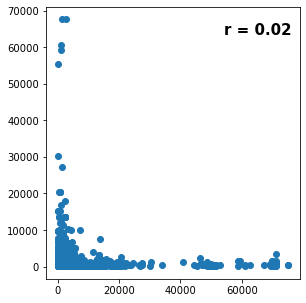

In [110]:
fig = plt.figure(figsize = (10, 5))


ax = fig.add_subplot(1,2,1)
ax.scatter(x = independent_variable, y = dependent_variable)
    
pearson_r = pearsonr(independent_variable, dependent_variable)[0]
ax.annotate(s = "r = {:.2f}".format(pearson_r),
            xy = (.7, .9),
            xycoords=ax.transAxes,
            color = "black",
            weight = "bold",
            fontsize = 15)

In [111]:
sisli_mask = airbnb_with_nn_results.loc[:,"district_e"] == "Sisli"
price_mask = airbnb_with_nn_results.loc[:,"price"] <= 800
combined_mask = sisli_mask & price_mask
subset = airbnb_with_nn_results.loc[combined_mask,:]

In [112]:
dependent_variable = subset.loc[:,"price"]
independent_variable = subset.loc[:,"distance_origin_to_centroid"]

Text(0.7, 0.9, 'r = 0.03')

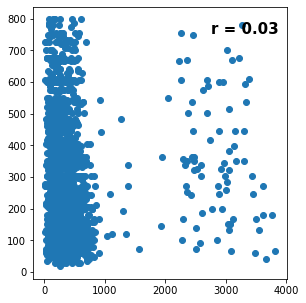

In [113]:
fig = plt.figure(figsize = (10, 5))


ax = fig.add_subplot(1,2,1)
ax.scatter(x = independent_variable, y = dependent_variable)
    
pearson_r = pearsonr(independent_variable, dependent_variable)[0]
ax.annotate(s = "r = {:.2f}".format(pearson_r),
            xy = (.7, .9),
            xycoords=ax.transAxes,
            color = "black",
            weight = "bold",
            fontsize = 15)

In [120]:
one_exp_mask = airbnb_with_nn_results.loc[:,"listing_id"] == int(33151050)
one_exp = airbnb_with_nn_results.loc[one_exp_mask,:]

In [121]:
one_exp

,listing_id,name,host_id,host_name,district_e,latitude,longitude,room_type,price,district_t,geometry,centroid,distance_origin_to_centroid
15864,33151050,One Bedroom Apartment in Sisli (near Cevahir M...,166855876,Anas,Sisli,41.06237,28.98726,Entire home/apt,278,Şişli,POINT (28.98726 41.06237),POINT (28.98726 41.06247),10.23016


In [122]:
one_exp.geometry

15864    POINT (28.98726 41.06237)
Name: geometry, dtype: geometry

In [123]:
sisli_geomask = istanbul_districts_gdf.loc[:,"district_e"] == "Sisli"
only_sisli = istanbul_districts_gdf.loc[sisli_geomask, :]

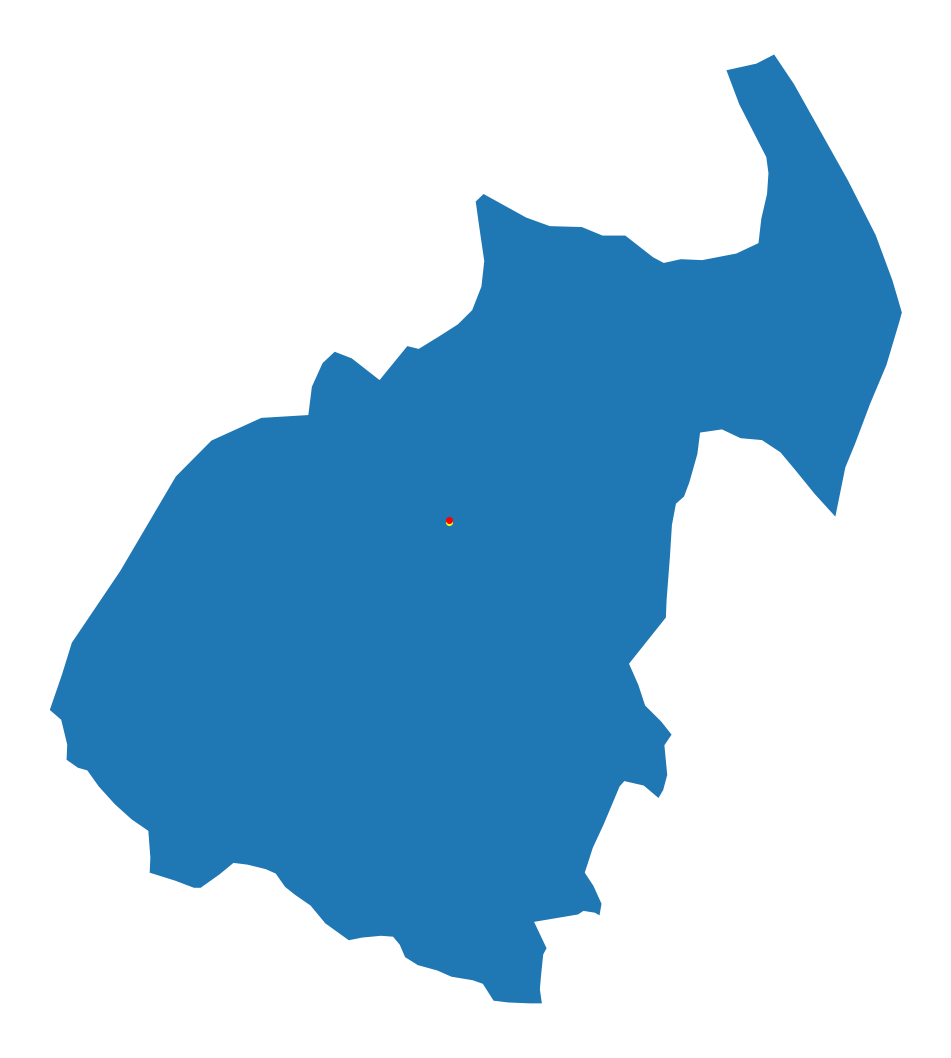

In [124]:
fig = plt.figure(figsize = (19.20,19.20))

ax_1 = fig.add_subplot(1,1,1)

#                            --- MAP: ---

# --- Plot Figure ---

only_sisli.plot(ax = ax_1)

one_exp.plot(ax = ax_1,
               color = "yellow",
               alpha = 1)

one_exp.set_geometry(one_exp.loc[:,"centroid"]).plot(ax = ax_1,
                                                   color = "red",
                                                    alpha = 1)

# --- Set Basemap ---


# --- Spine and Grid ---

ax_1.set_axis_off() # Turn off axis